# Analysis of Delays in the US Air Transport
## by Jesús Mira Aldao

## Investigation Overview

The main purpose of this investigation is to analyze the different causes of delay in the US air transport. We are interested in knowing how they change depending on the location of the airport (in this case we have chose the departure airport), the day of the week and the month. As an additional resarch we have analysed possible routes in which can be feaseble to promote another means of transport as the high speed train, hyperloop, etc. To do that we have chose those routes between airports with a mean of more than 15 flights per day and with a mean speed below 250 km/h because in this conditions a train might be able to compete with the plane in capabilities.

## Dataset Overview

The original data to develop this research was obtained from the web page [Statistical Computing-Statistical Graphics](http://stat-computing.org/dataexpo/2009/the-data.html). It has up to 120 million observations of flights with variables like:
* Dates: day of week, date, month, year
* Arrival and departure times: actual and scheduled.
* Flight times: actual and scheduled.
* Delays of different causes.
* Origin and destination: airport code, latitude, longitude.
* Carrier.



## Relationship Between Variables of Time in the Dataset

![alt text](pictures/Graphic_Times.jpg)

In [91]:
#basic data libraries
import pandas as pd
import numpy as np
#to interact with the local system
import os
import sys
import psutil

#imports to user timers and make conversions of time formats
from timeit import default_timer as timer
from datetime import datetime
import time

#import for stats
import statsmodels.api as sm
import random

#import to calculate if a point is inside a polygo.
#it is necessary to divide the airports in geographical regions
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

#imports to plot maps.
import plotly.express as px
import plotly.graph_objects as go

#matplotlib to display plots
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("talk")

plt.style.use('seaborn-deep')
%matplotlib inline
random.seed(30)

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [92]:
# load in the dataset into a pandas dataframe
#Load the dataframe with the 500000 samples of 2008
folder_name = "data"
df_2008 = pd.read_csv(folder_name + '/2008_samp.csv.bz2', index_col=None, header=0)
#We load the file with mean values by day for Origins.
df_origins = pd.read_csv(folder_name + '/OriginByDay.csv.bz2', index_col=None, header=0)
#We load the file with mean values by day for Routes
df_routes = pd.read_csv(folder_name + '/RouteByDay.csv.bz2', index_col=None, header=0)
#We load the data file with the data of airports
df_airports_inf = pd.read_csv('data/airports.csv', index_col=None, header=0)

In [93]:
#convert region into a categorical ordinal variable.
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_airports_inf['region'] = df_airports_inf['region'].astype(ordered_region)

#It changes the Type of the Date Time columns to String.
df_2008['Year'] = df_2008['Year'].astype(str)
df_2008['Month'] = df_2008['Month'].astype(str).str.zfill(2)
df_2008['DayofMonth'] = df_2008['DayofMonth'].astype(str).str.zfill(2)
df_2008['DayOfWeek'] = df_2008['DayOfWeek'].astype(str)
#It creates a new column with the date.
df_2008['Date'] = df_2008['Year'] + '-' + df_2008['Month'] + '-' + df_2008['DayofMonth']

#convert month to a ordered categorical variable
ordered_month = pd.api.types.CategoricalDtype(ordered = True, categories = ['01', '02', '03', '04', '05', '06',
                                                                            '07', '08', '09', '10', '11', '12'])
df_2008['Month'] = df_2008['Month'].astype(ordered_month)


#convert dayofweek to a ordered categorical variable
ordered_dow = pd.api.types.CategoricalDtype(ordered = True, categories = ['1', '2', '3', '4', '5', '6', '7'])
df_2008['DayOfWeek'] = df_2008['DayOfWeek'].astype(ordered_dow)

df_2008['TotalDelay'] = df_2008['CarrierDelay'] +\
                        df_2008['WeatherDelay'] +\
                        df_2008['NASDelay'] +\
                        df_2008['SecurityDelay'] +\
                        df_2008['LateAircraftDelay']

In [94]:
#I add the comun region to the dataframe df_origins
df_origins['Region'] = df_origins.Origin.map(df_airports_inf.set_index('iata')['region'].to_dict())
ordered_dow = pd.api.types.CategoricalDtype(ordered = True, categories = [1, 2, 3, 4, 5, 6, 7])
df_origins['DayOfWeek'] = df_origins['DayOfWeek'].astype(ordered_dow)


In [95]:
#It calculates the Total Delay
df_routes['TotalDelay'] = df_routes['CarrierDelay'] +\
                          df_routes['WeatherDelay'] +\
                          df_routes['NASDelay'] +\
                          df_routes['SecurityDelay'] +\
                          df_routes['LateAircraftDelay']

#It divides the route column in two columns: Origin and Dest.
df_routes['Origin'], df_routes['Dest'] = df_routes['Route'].str.split('-', 1).str

#It merge the dataframe df_routes with columns about the data of the airport of origin
df_routes = df_routes.merge(df_airports_inf, how='left',left_on=['Origin'], right_on = ['iata'])
df_routes = df_routes.rename(columns = {'city': 'City_Origin', 'airport': 'Airport_Origin',
                                        'state': 'State_Origin', 'country': 'Country_Origin',
                                        'lat': 'Lat_Origin', 'long': 'Long_Origin'})
df_routes = df_routes.drop(columns = ['iata'])

#It merge the dataframe df_routes with columns about the data of the airport of destiny
df_routes = df_routes.merge(df_airports_inf, how='left',left_on=['Dest'], right_on = ['iata'])
df_routes = df_routes.rename(columns = {'city': 'City_Dest', 'airport': 'Airport_Dest', 
                                        'state': 'State_Dest', 'country': 'Country_Dest', 
                                        'lat': 'Lat_Dest', 'long': 'Long_Dest'})
df_routes = df_routes.drop(columns = ['iata'])

#It adds two columns with the difference in Latitud and Longitud. It converts the coordenates to int
df_routes['Difference_Long'] = (df_routes['Long_Dest']-df_routes['Long_Origin']).astype(int)
df_routes['Difference_Lat'] = (df_routes['Lat_Dest']-df_routes['Lat_Origin']).astype(int)

#We group all the dataframe by de difference in longitude
df_routes_long = df_routes.groupby(['Difference_Long']).mean()
df_routes_long = df_routes_long.reset_index()

#We group all the dataframe by de difference in latitiude
df_routes_lat = df_routes.groupby(['Difference_Lat']).mean()
df_routes_lat = df_routes_lat.reset_index()

## Distribution of the Air Time of the Flights

The distribution of the airtime is highly right skewed with values from a few minutes to up 600 hundred minutes. If we draw it in a graph using a logarithmic scale for the minutes we can see that tends to follows a log-normal distribution. This is somtehing that also happens with the distance, the elapsed time and with some delays.

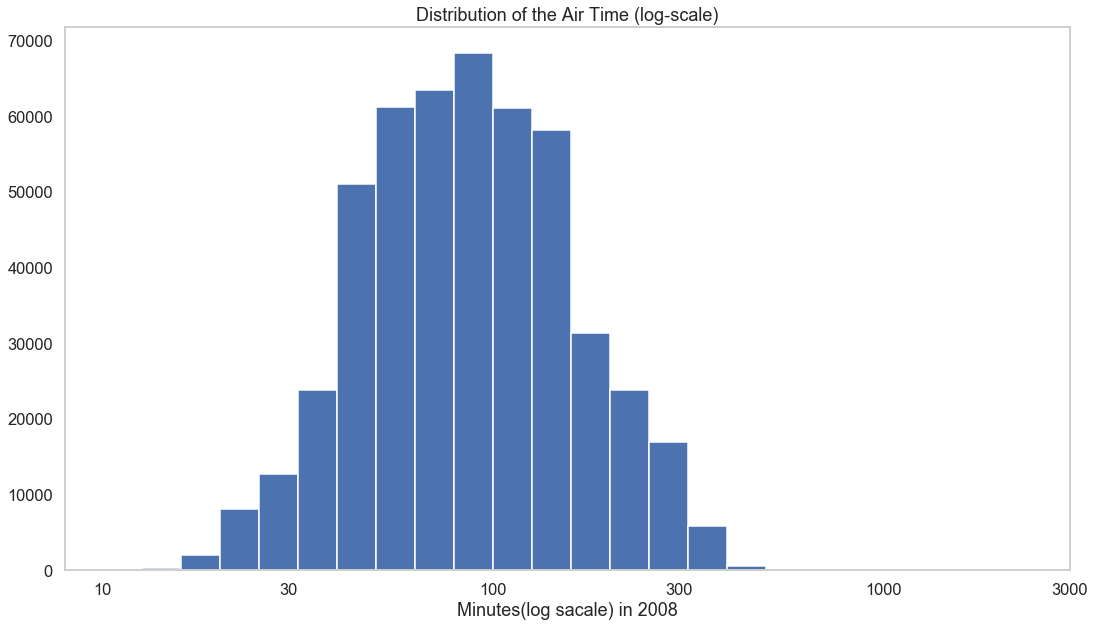

In [96]:
#It plots the log distribution of the air time
plt.figure(figsize = [18, 10])
bin_edges = 10 ** np.arange(1, np.log10(df_2008['AirTime'].max())+0.1, 0.1)
plt.hist(df_2008['AirTime'], bins = bin_edges)
plt.title('Distribution of the Air Time (log-scale)')
plt.xscale('log')
plt.xlabel('Minutes(log sacale) in 2008')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs);



## Distribution of NAS and Late Aircrafts Delays

As it occurs with the airtime the delays usually are long tailed right skewed. In some cases there are a tendency to update them in fixed periods as 5 or 15 minutes. I show two examples in this slide in which 15 minutes seems to be a time frequently used.

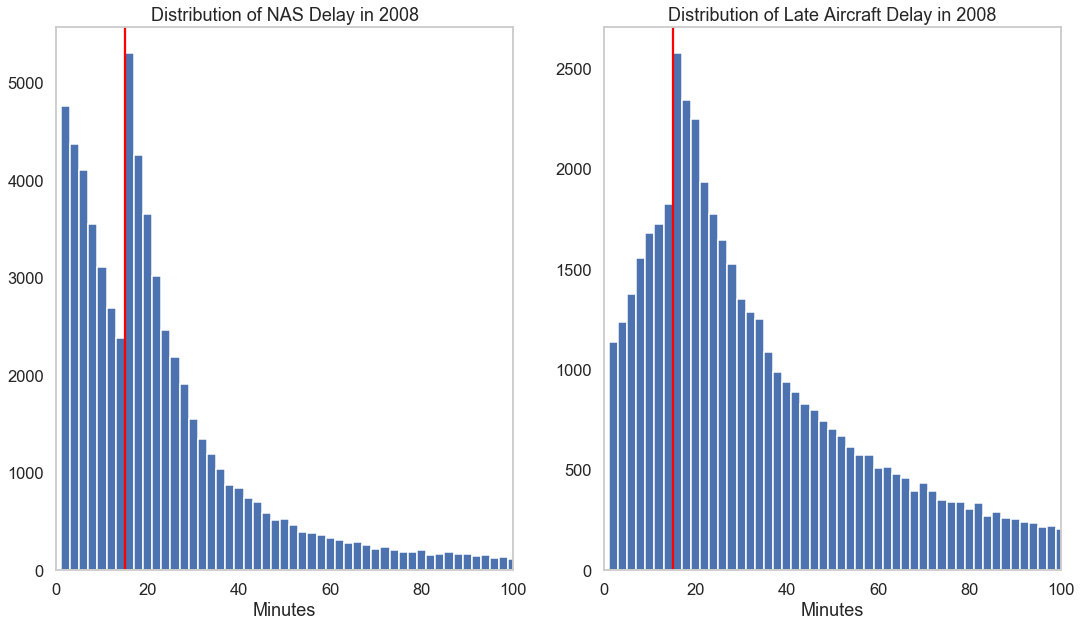

In [97]:
plt.figure(figsize = [18, 10])

#Distribution of the NAS Delay
plt.subplot(1, 2, 1)
bin_edges = np.arange(1, df_2008['NASDelay'].max()+2, 2)
sns.distplot(df_2008['NASDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
#red line in 15 minutes
plt.xlabel('Minutes')
plt.title('Distribution of NAS Delay in 2008')
plt.axvline(x= 15, color='r');
plt.xlim(0, 100)


#Distribution of the Late Aircraft Delay
plt.subplot(1, 2, 2)
bin_edges = np.arange(1, df_2008['LateAircraftDelay'].max()+2, 2)
sns.distplot(df_2008['LateAircraftDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
plt.xlabel('Minutes')
plt.title('Distribution of Late Aircraft Delay in 2008')
#red line in 15 minutes
plt.axvline(x= 15, color='r');
plt.xlim(0, 100);

## Linear Relationship Between Time Variables

We can find several linear relationships between the time variables. I show here two of them. 

* In the first case we can se the relationship between the Actual Elapsed Time and the Scheduled Time. They follow a linear relationship one to one, but we can see that the spread is clearly bigger in those flights under 400 minutes of duration. The vertical lines in the left side are those flights that has not took off.

* In the second case we can observe also the linear relationship between the arrival and departure delays for those with values under 500 minutes. The linearity is clear, especially for big values. In small or normal values we observe that many other causes influence in the arrival delay and tend to have greater values than the departure delay. But we also observe that in many cases both of them can be negative, but we this can be normal because a flight can departure or arrive before the time schedulled.




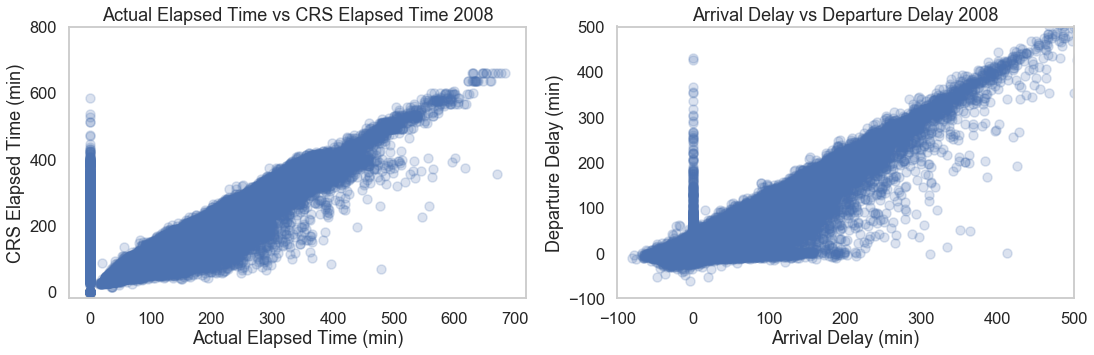

In [98]:
plt.figure(figsize = [18, 5])

#scatter plot between 'ActualElapsedTime' and 'CRSElapsedTime'.
plt.subplot(1, 2, 1)
plt.scatter(data = df_2008, x = 'ActualElapsedTime', y = 'CRSElapsedTime', alpha=0.2)
plt.ylim(-20, 800)
plt.xlabel('Actual Elapsed Time (min)')
plt.ylabel('CRS Elapsed Time (min)')
plt.title('Actual Elapsed Time vs CRS Elapsed Time 2008')

#enlargment of the relationship between ArrDelay and DepDelay around 0.
plt.subplot(1, 2, 2)
plt.scatter(data = df_2008, x = 'ArrDelay', y = 'DepDelay', alpha=0.2);
plt.xlabel('Arrival Delay (min)')
plt.ylabel('Departure Delay (min)')
plt.title('Arrival Delay vs Departure Delay 2008')
plt.xlim(-100, 500)
plt.ylim(-100, 500);

## Division of the Country in Five Regions

Before continue with the analysis we have divided the country in five geographical regions because we want to analyze the behaviour of the of the delays according the location of the airport of departure.


* Hawaii


* Alaska


* Continent West


* Continent Center


* Continen East

The result is showed in the picture below.

![Airports by Region](pictures/Regions.jpg)

In [99]:
#add a new colum with the sum of all the main delays.
df_2008['TotalDelay'] = df_2008['CarrierDelay'] +\
                        df_2008['WeatherDelay'] +\
                        df_2008['NASDelay'] +\
                        df_2008['SecurityDelay'] +\
                        df_2008['LateAircraftDelay']
#It defines four list with the numeric variables
numeric_vars_duration = ['ActualElapsedTime', 'CRSElapsedTime', 'AirTime' ,'Distance']
numeric_vars_delay = ['TotalDelay', 'ArrDelay', 'DepDelay', 
                      'LateAircraftDelay' ,'CarrierDelay', 'NASDelay', 'WeatherDelay', 'SecurityDelay', 
                      'TaxiOut', 'TaxiIn']
numeric_log_vars_duration = ['Log_ActualElapsedTime', 'Log_CRSElapsedTime', 'Log_AirTime' ,'Log_Distance']
numeric_log_vars_delay = ['Log_TotalDelay', 'Log_ArrDelay', 'Log_DepDelay', 
                          'Log_LateAircraftDelay' ,'Log_CarrierDelay', 'Log_NASDelay', 'Log_WeatherDelay', 'Log_SecurityDelay', 
                          'Log_TaxiOut', 'Log_TaxiIn']

#Makes a copy of df_2008 and filter by not cancelled flights
df_2008_copy = df_2008.query('Cancelled == 0')
#Change the cero value in all the numerci columns
num = df_2008_copy._get_numeric_data()
num[num == 0] = 1
# compute the logarithm of delays
def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)
    
#add new columns with the logarithm of the variables of delays
df_2008_copy['Log_Distance'] = df_2008_copy['Distance'].apply(log_trans)


#I add the colum region to the dataframe with the information in df_airports_inf
df_2008_copy['Region'] = df_2008_copy.Origin.map(df_airports_inf.set_index('iata')['region'].to_dict())

#convert region into a categorical ordinal variable.
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_2008_copy['Region'] = df_2008_copy['Region'].astype(ordered_region)



## Distribution of the Distance by Region

The distribution of the distance of the flights is very different from one regions to others.

 * For example, Hawaii has two main different nodules, one for the inner traffic between the islands and other for the flights to the continent. 
 
 * Alaska has a shape elonged and quite uniform. It not exist a clear preference between short and long flights over 200 miles.
    
 * Between the three areas in the continent there are also some differences. The west region has the greater proportion of long flights, maybe influenced by the flights to Hawaii, but it has a clear increment in the first quartile around 300 miles.
  
 * The center and east regions are very simiral, but the East Region has small apendix in the upper side. The proportion of the longest flights it is not so iportant as in the West Coast.
    
 * The Center Region has its biggest proportion of flights in the third quartile, while the East Coast has the maximum proportion around the first quartile.
    

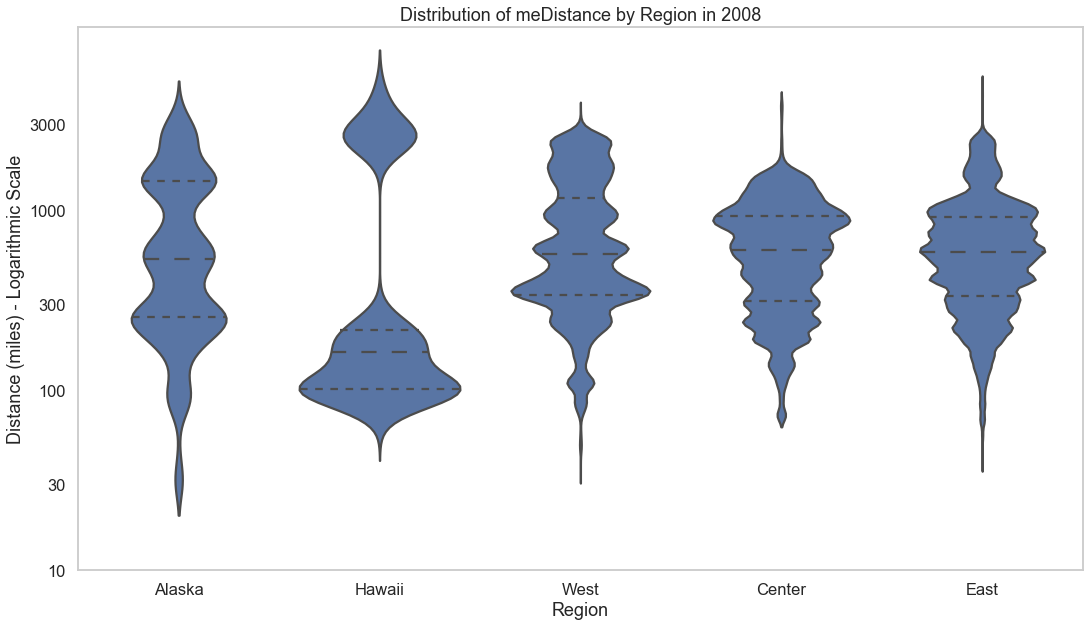

In [100]:
#violin plots of 'Log_Distance' by 'region'

default_color = sns.color_palette()[0]
fig, ax = plt.subplots(ncols = 1, nrows = 1 , figsize = [18,10])
sns.violinplot(data = df_2008_copy, x = 'Region', y = 'Log_Distance',
               color = default_color, inner = 'quartile')
tick_locs = [10, 30, 100, 300, 1000, 3000]
ax.set_yticks(log_trans([10, 30, 100, 300, 1000, 3000]))
ax.set_yticklabels([10, 30, 100, 300, 1000, 3000])
plt.xlabel('Region')
plt.ylabel('Distance (miles) - Logarithmic Scale')
plt.title('Distribution of the Distance by Region in 2008')
plt.show()

In [101]:
#we recover the original data fo df_origins, filter by year and group by Region and DayOfWeek
df_origin_by_day = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'DayOfWeek']).agg({'Count': 'sum'})

#It create a column with the percentage of flights in a day per week. For each region
df_origin_by_day = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'DayOfWeek']).agg({'Count': 'sum'})
df_origin_by_day_pcts = df_origin_by_day.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

#reset the index and rename de column Count.
df_origin_by_day_pcts = df_origin_by_day_pcts.reset_index()
df_origin_by_day_pcts = df_origin_by_day_pcts.rename(columns = {'Count' : 'Percentage_Origin'})

#Change the name of the days
df_origin_by_day_pcts['DayOfWeek'] = df_origin_by_day_pcts['DayOfWeek'].map({1: 'Monday', 
                                                                               2: 'Tuesday',
                                                                               3: 'Wednesday',
                                                                               4: 'Thursday',
                                                                               5: 'Friday',
                                                                               6: 'Saturday',
                                                                               7: 'Sunday'})
#set an order to the geographical regions
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_day_pcts['Region'] = df_origin_by_day_pcts['Region'].astype(ordered_region)

## Percentage of Flights by Day of Week for Each Region

Regarding how the traffic is distributed in the week we can draw the next conclusions:


* The propotion of flights along the week is almost constant in Alaska.


* It suffers a little increment on Friday and Saturday in Hawaii.


* It is almost constant in workdays in the continent with a big decrement on Saturdays an increment again on Sundays. 

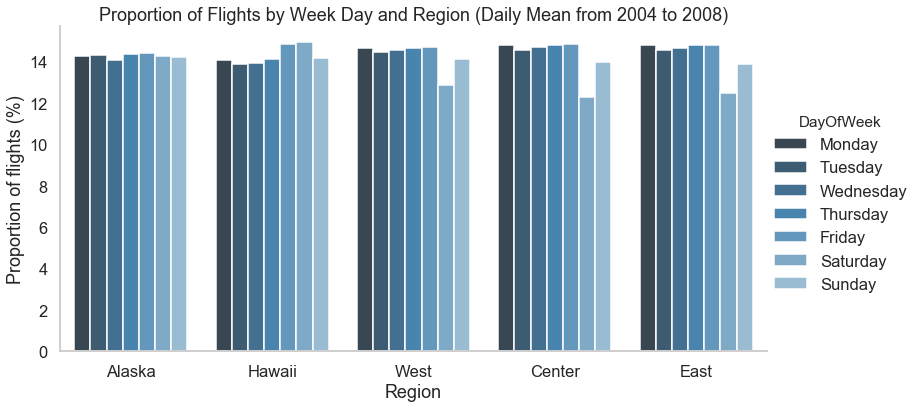

In [130]:
sns.set_palette("Blues_d", 7);

g = sns.catplot(x='Region', y='Percentage_Origin', 
                   hue='DayOfWeek', data=df_origin_by_day_pcts, 
                   kind='bar', height=5.5, aspect=2, legend_out=True)
plt.ylabel('Proportion of flights (%)')
plt.title('Proportion of Flights by Week Day and Region (Daily Mean from 2004 to 2008)');

In [103]:
#we get a new copy of tthe dataset df_origins filtered by year and grouped bu region and day of week
df_origin_by_day = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'DayOfWeek']).mean()
df_origin_by_day = df_origin_by_day.reset_index()

#It changes the name of the days
df_origin_by_day['DayOfWeek'] = df_origin_by_day['DayOfWeek'].map({1: 'Monday', 
                                                                   2: 'Tuesday',
                                                                   3: 'Wednesday',
                                                                   4: 'Thursday',
                                                                   5: 'Friday',
                                                                   6: 'Saturday',
                                                                   7: 'Sunday'})
#We add the column Total Delay
df_origin_by_day['TotalDelay'] = df_origin_by_day['CarrierDelay'] +\
                                 df_origin_by_day['WeatherDelay'] +\
                                 df_origin_by_day['NASDelay'] +\
                                 df_origin_by_day['SecurityDelay'] +\
                                 df_origin_by_day['LateAircraftDelay']

#convert region into a categorical ordinal variable.
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_day['Region'] = df_origin_by_day['Region'].astype(ordered_region)

## Delays by Region and Day of Week


 * Alaska is the region with a greater delay mainly because of the Aircraft Delay. They have also a much bigger Security Delay comparatively with other regions, but this is very small and don't has a great impact in the total.
    
 * Hawaii is the region with less delay, but if we focus in the Departure and Arrival Delays we can see a strange pattern. We have seen before that they usually have negative departures and arrival delays, but here we observe that these are more negative on mondays and then go increasing along the week to remain positive on the weekend. 
 
 * The weather delay is specially important in the Center Region and in the East Coast, but it does not almost exist in Hawaii. 
    
 * In general the delays are high on Mondays, dercrease on Tuesdays and then go increasing along the week to decrease again on Saturdays and increase on Sundays.
 
 In the slides below we show some examples.

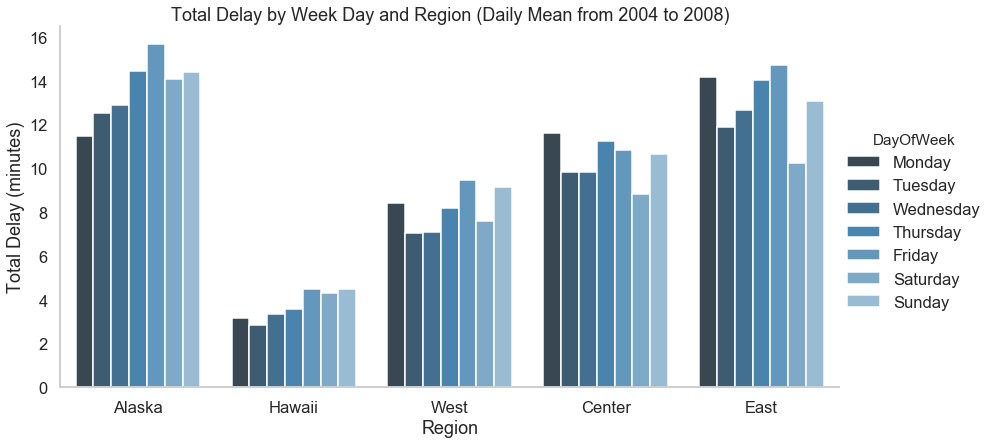

In [104]:
#It draws the factor plot with the delays of TotalDelay.

sns.set_palette("Blues_d", 7);

sns.catplot(x='Region', y='TotalDelay', 
            hue='DayOfWeek', data=df_origin_by_day, 
            kind='bar', height=6, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Total Delay (minutes)')
plt.title('Total Delay by Week Day and Region (Daily Mean from 2004 to 2008)');
plt.show();

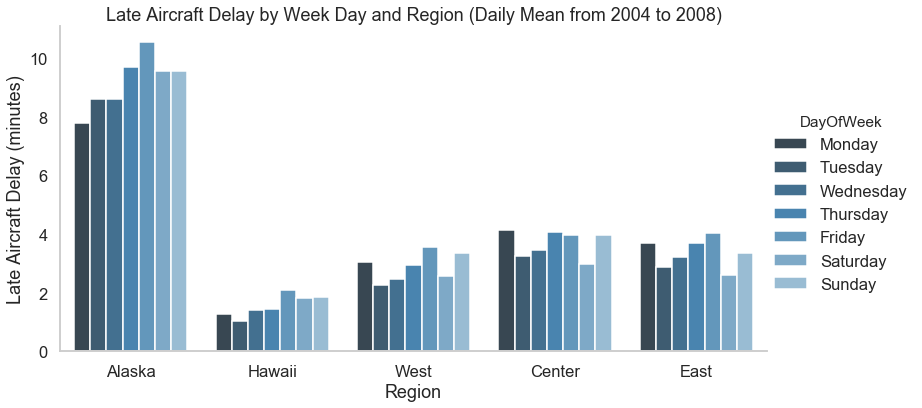

In [105]:
#It draws the factor plot with the Late Aircraft Delays.

sns.set_palette("Blues_d", 7);

sns.catplot(x='Region', y='LateAircraftDelay', 
            hue='DayOfWeek', data=df_origin_by_day, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Late Aircraft Delay (minutes)')
plt.title('Late Aircraft Delay by Week Day and Region (Daily Mean from 2004 to 2008)');
plt.show();

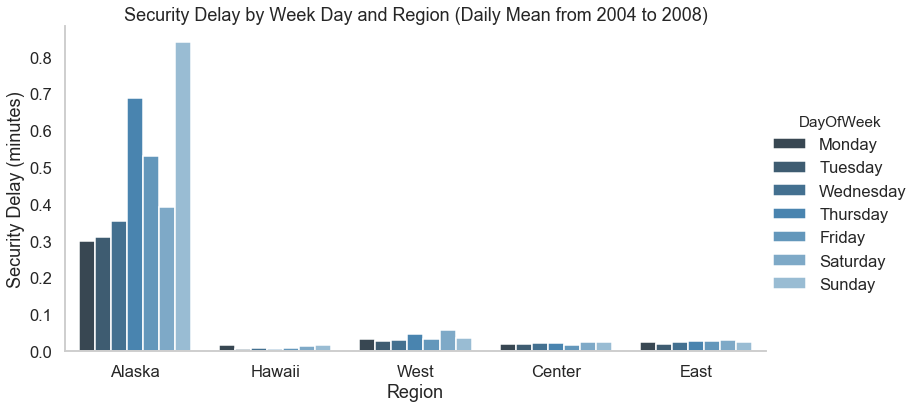

In [106]:
#It draws the factor plot with the Security Delay.

sns.set_palette("Blues_d", 7);

sns.catplot(x='Region', y='SecurityDelay', 
            hue='DayOfWeek', data=df_origin_by_day, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Security Delay (minutes)')
plt.title('Security Delay by Week Day and Region (Daily Mean from 2004 to 2008)');
plt.show();

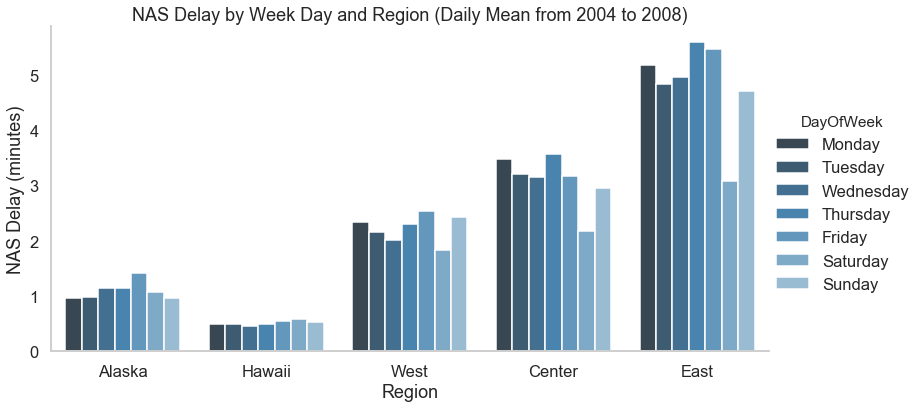

In [107]:
#It draws the factor plot with the NAS Delay.

sns.set_palette("Blues_d", 7);

sns.catplot(x='Region', y='NASDelay', 
            hue='DayOfWeek', data=df_origin_by_day, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('NAS Delay (minutes)')
plt.title('NAS Delay by Week Day and Region (Daily Mean from 2004 to 2008)');
plt.show();

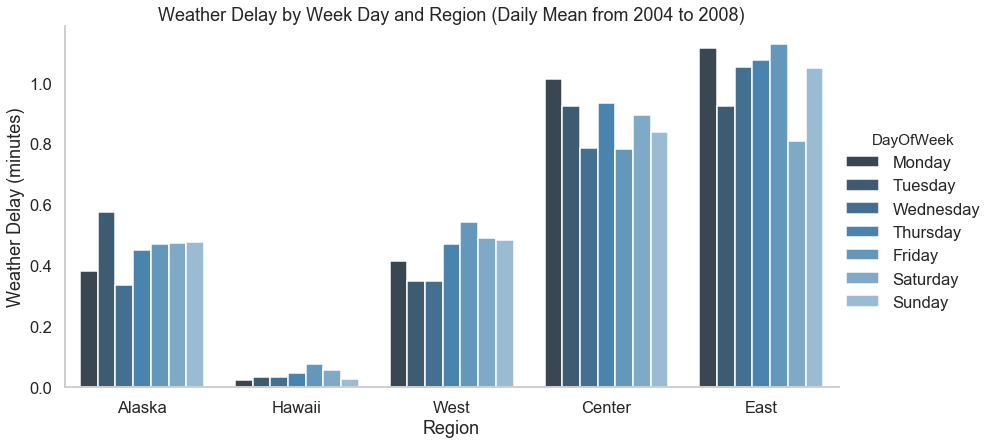

In [108]:
#It draws the factor plot with the Arrival Delay.

sns.set_palette("Blues_d", 7);

sns.catplot(x='Region', y='WeatherDelay', 
            hue='DayOfWeek', data=df_origin_by_day, 
            kind='bar', height=6, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Weather Delay (minutes)')
plt.title('Weather Delay by Week Day and Region (Daily Mean from 2004 to 2008)');
plt.show();

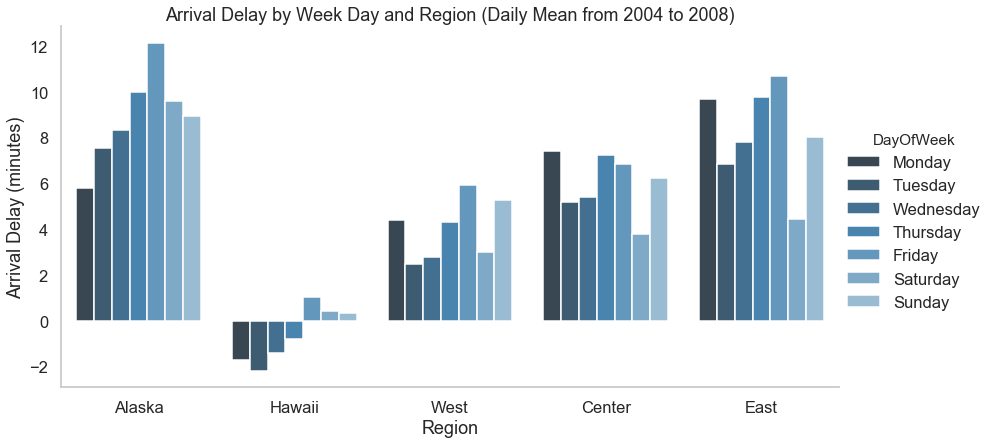

In [109]:
#It draws the factor plot with the Arrival Delay.

sns.set_palette("Blues_d", 7);

sns.catplot(x='Region', y='ArrDelay', 
            hue='DayOfWeek', data=df_origin_by_day, 
            kind='bar', height=6, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Arrival Delay by Week Day and Region (Daily Mean from 2004 to 2008)');
plt.show();

In [110]:
df_origin_by_month = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'Month']).agg({'Count': 'sum'})
df_origin_by_month_pcts = df_origin_by_month.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
df_origin_by_month_pcts = df_origin_by_month_pcts.rename(columns = {'Count' : 'Percentage_Origin'})

df_origin_by_month_pcts = df_origin_by_month_pcts.reset_index()
df_origin_by_month_pcts['Month'] = df_origin_by_month_pcts['Month'].map({1: 'January', 
                                                                         2: 'February',
                                                                         3: 'March',
                                                                         4: 'April',
                                                                         5: 'May',
                                                                         6: 'June',
                                                                         7: 'July',
                                                                         8: 'August',
                                                                         9: 'September',
                                                                         10: 'October',
                                                                         11: 'November',
                                                                         12: 'December'})

#set an order to the geographical regions
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_month_pcts['Region'] = df_origin_by_month_pcts['Region'].astype(ordered_region)

## Percentage of Flights by Month for Each Region

* Regarding to the month of the year we can see that the region that have the biggest variation of traffic between months is Alaska. The percentage of traffic is really gigger in the summer months. In the other regions this fifference between months is not so big, although Hawaii has also a considerably increment of traffic in July and August.

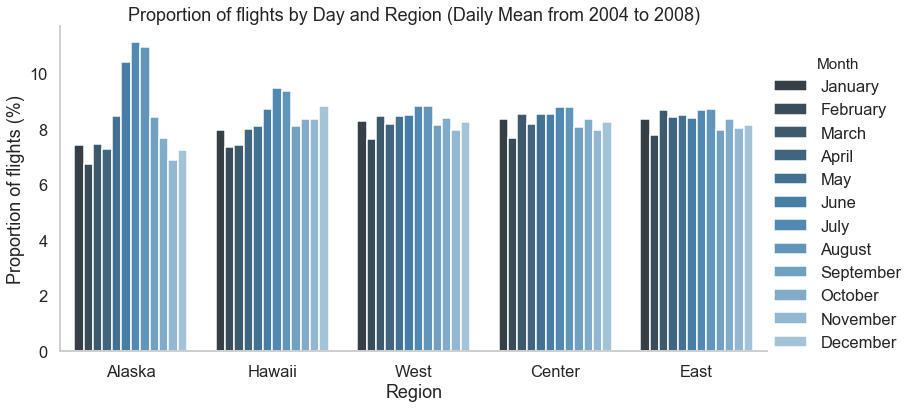

In [111]:
sns.set_palette("Blues_d", 12);

g = sns.catplot(x='Region', y='Percentage_Origin', 
                   hue='Month', data=df_origin_by_month_pcts, 
                   kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Proportion of flights (%)')
plt.title('Proportion of flights by Day and Region (Daily Mean from 2004 to 2008)')
plt.show()

In [112]:
#we get a new copy of tthe dataset df_origins filtered by year and grouped bu region and month
df_origin_by_month = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'Month']).mean()
df_origin_by_month = df_origin_by_month.reset_index()
#It changes the name of the days
df_origin_by_month['Month'] = df_origin_by_month['Month'].map({1: 'January', 
                                                               2: 'February',
                                                               3: 'March',
                                                               4: 'April',
                                                               5: 'May',
                                                               6: 'June',
                                                               7: 'July',
                                                               8: 'August',
                                                               9: 'September',
                                                               10: 'October',
                                                               11: 'November',
                                                               12: 'December'})
#We add the column Total Delay
df_origin_by_month['TotalDelay'] = df_origin_by_month['CarrierDelay'] +\
                                   df_origin_by_month['WeatherDelay'] +\
                                   df_origin_by_month['NASDelay'] +\
                                   df_origin_by_month['SecurityDelay'] +\
                                   df_origin_by_month['LateAircraftDelay']

#set an order to the geographical regions
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_month['Region'] = df_origin_by_month['Region'].astype(ordered_region)

## Delays by Region and Month



* December is a bad month to travel in all the regions. Janueary, February and March are also bad except in Hawaii.


* Finally June, July and August are also bad months, expecially in the East Coast and in Alaska. In this region must be very important that they have a great amount of traffic these months. In the case of the East Region all the causes of delay suffer an increment these months but we can remark the increment in the Wheather delays surely because of the Hurricans Season.


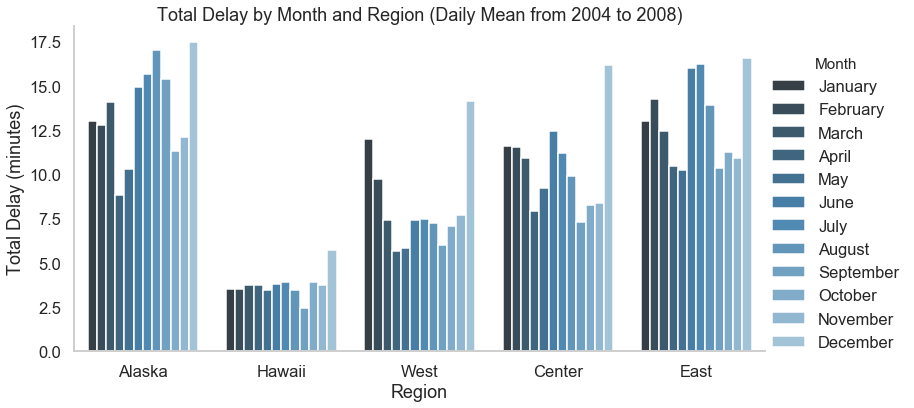

In [113]:
#It draws the factor plot with the results of Total Delay.
sns.set_palette("Blues_d", 12);
sns.catplot(x='Region', y='TotalDelay', 
            hue='Month', data=df_origin_by_month, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Total Delay (minutes)')
plt.title('Total Delay by Month and Region (Daily Mean from 2004 to 2008)')
plt.show()
plt.show();

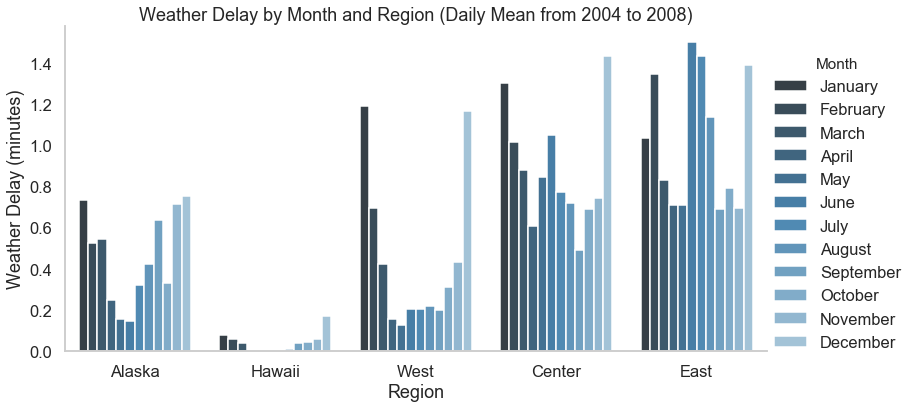

In [114]:
#It draws the factor plot with the results of Weather Delay.
sns.set_palette("Blues_d", 12);
sns.catplot(x='Region', y='WeatherDelay', 
            hue='Month', data=df_origin_by_month, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Weather Delay (minutes)')
plt.title('Weather Delay by Month and Region (Daily Mean from 2004 to 2008)')
plt.show();

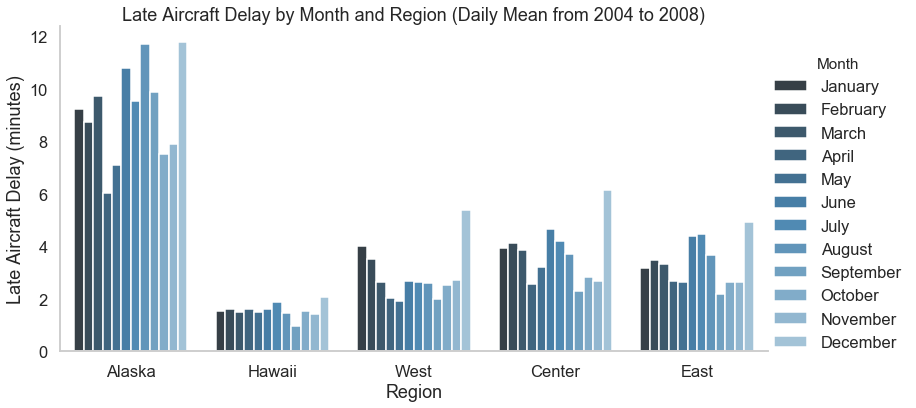

In [115]:
#It draws the factor plot with the results of Weather Delay.
sns.set_palette("Blues_d", 12);
sns.catplot(x='Region', y='LateAircraftDelay', 
            hue='Month', data=df_origin_by_month, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Late Aircraft Delay (minutes)')
plt.title('Late Aircraft Delay by Month and Region (Daily Mean from 2004 to 2008)')
plt.show();

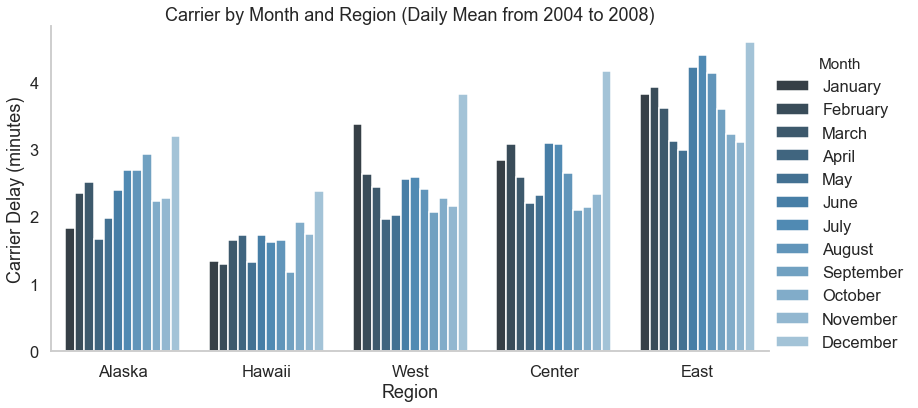

In [116]:
#It draws the factor plot with the results of Weather Delay.
sns.set_palette("Blues_d", 12);
sns.catplot(x='Region', y='CarrierDelay', 
            hue='Month', data=df_origin_by_month, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Carrier Delay (minutes)')
plt.title('Carrier by Month and Region (Daily Mean from 2004 to 2008)')
plt.show();

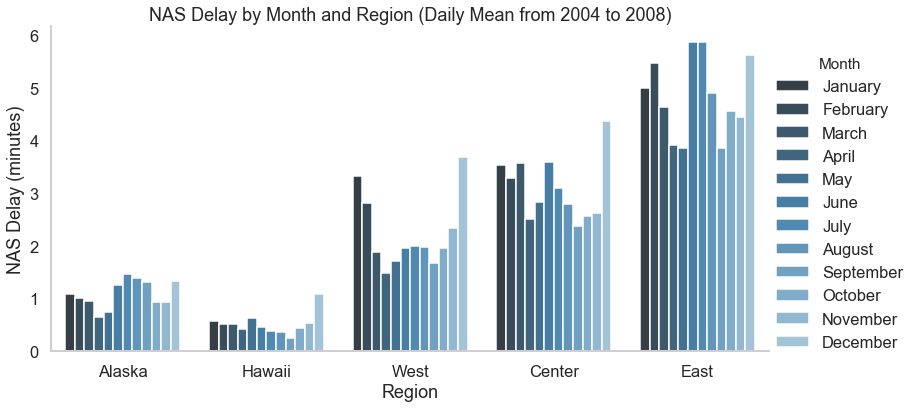

In [117]:
#It draws the factor plot with the results of Weather Delay.
sns.set_palette("Blues_d", 12);
sns.catplot(x='Region', y='NASDelay', 
            hue='Month', data=df_origin_by_month, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('NAS Delay (minutes)')
plt.title('NAS Delay by Month and Region (Daily Mean from 2004 to 2008)')
plt.show();

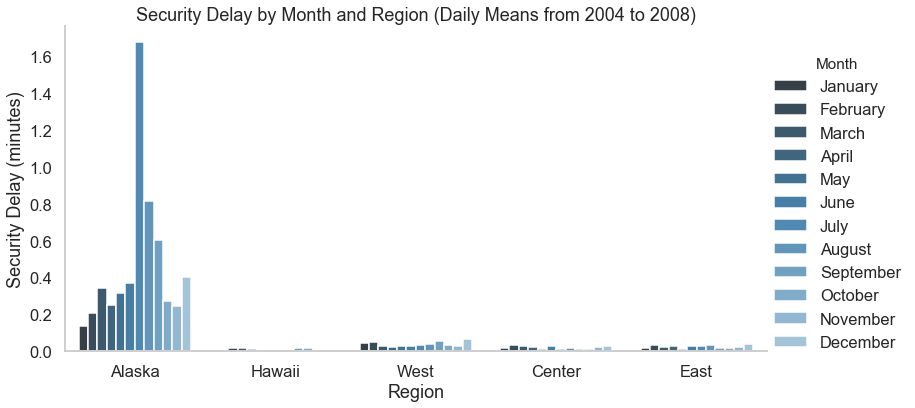

In [118]:
#It draws the factor plot with the results of Weather Delay.
sns.set_palette("Blues_d", 12);
sns.catplot(x='Region', y='SecurityDelay', 
            hue='Month', data=df_origin_by_month, 
            kind='bar', height=5.5, aspect=2, legend_out=True)
plt.xlabel('Region')
plt.ylabel('Security Delay (minutes)')
plt.title('Security Delay by Month and Region (Daily Means from 2004 to 2008)')
plt.show();

## Delay Depending on the Direction

We have don this analysis because we have seen that the geographical location of the airport of departure is very important in the caracteristics of the flights. We would like to know also if the differences between the locations of the airports could be also imortant.

* It seems that the total delay is bigger if we travel to the West than if we travel to the East, while there is no diference in the North and South directions. We could think that the movement of rotation of the Earth has some influence on that. But if it is so, to move to the West, against the rotation of the Earth should suppose a decrement in the time to get the destiny. It could been happening that the companies take this into account and they priorize one direction over another to compensate the influence of the earth movement? It is really strange. It could be also because of simply different condition of the winds.

* We can also see that the spread of the delays increases a lot for more than 40º of difference in horizontal and 18º in vertical. 

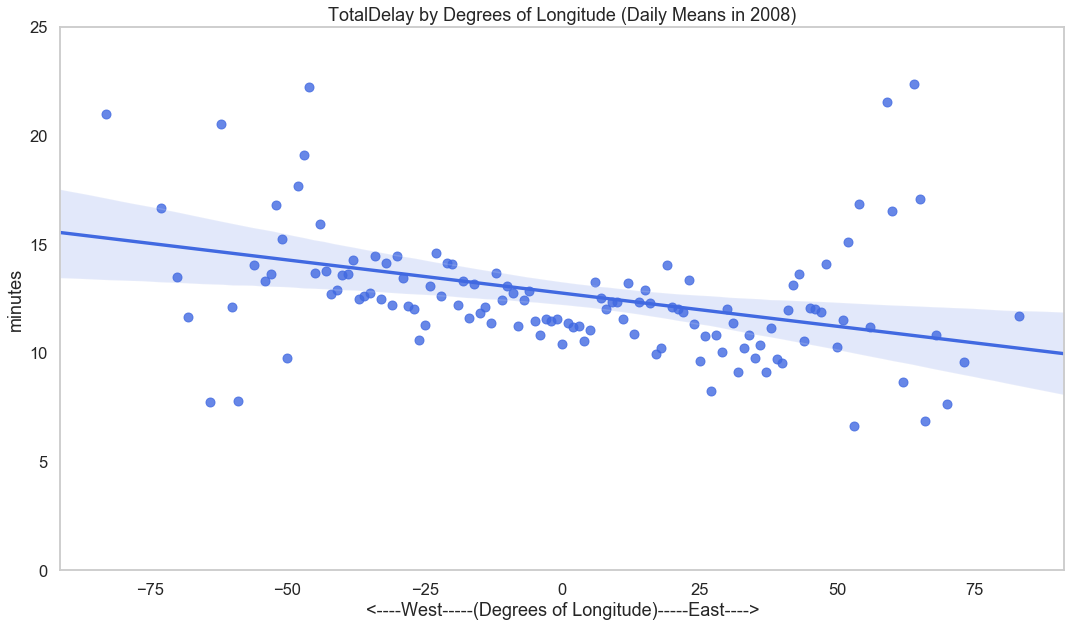

In [221]:
fig, ax = plt.subplots(ncols = 1, nrows = 1 , figsize = [18,10])

#It draws a regplot with the difference in long in the x-axis and the Carrier delay in the y-axis 
sns.regplot(x="Difference_Long", y="TotalDelay", data=df_routes_long, color="royalblue");
ax.set_ylim(0,25)
ax.set_xlabel('<----West-----(Degrees of Longitude)-----East---->')
ax.set_ylabel('minutes')
ax.set_title('TotalDelay by Degrees of Longitude (Daily Means in 2008)')
plt.show();


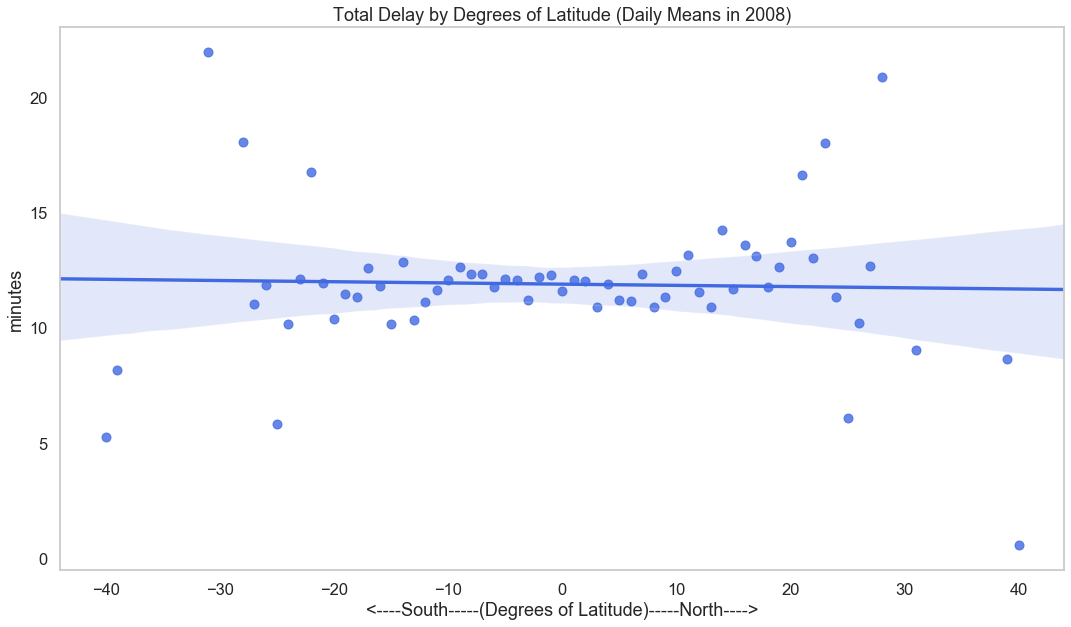

In [222]:
fig, ax = plt.subplots(ncols = 1, nrows = 1 , figsize = [18,10])
#It draws a regplot with the difference in latitude in the x-axis and the total delay in the y-axis 
sns.regplot(x="Difference_Lat", y="TotalDelay", data=df_routes_lat, color="royalblue");
ax.set_xlabel('<----South-----(Degrees of Latitude)-----North---->')
ax.set_ylabel('minutes')
ax.set_title('Total Delay by Degrees of Latitude (Daily Means in 2008)')
plt.show();

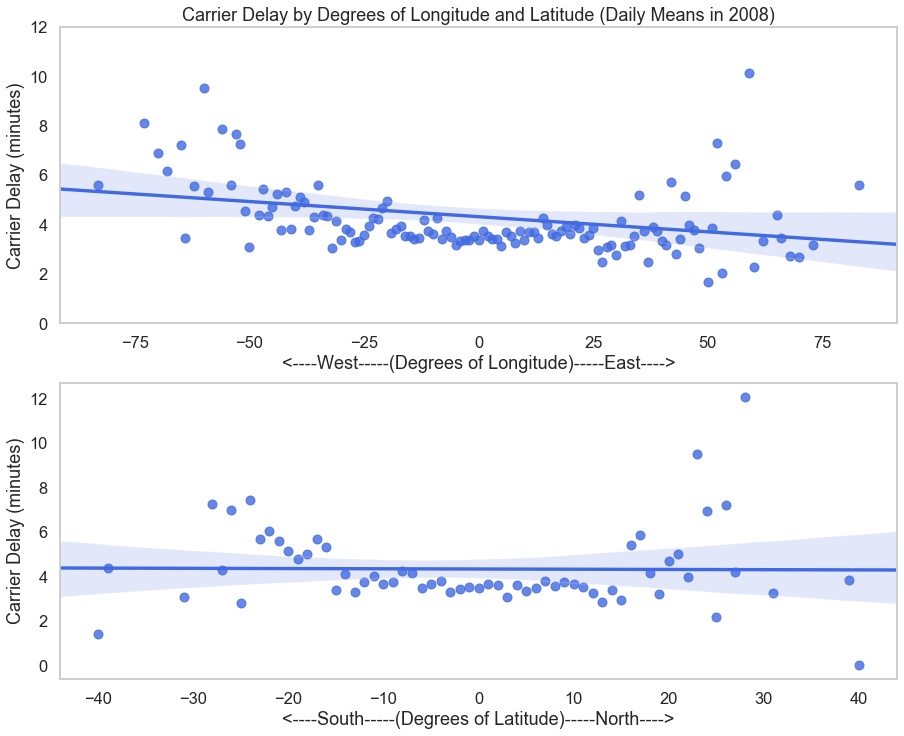

In [228]:
fig, ax = plt.subplots(nrows = 2, figsize = [15,12])

#It draws a regplot with the difference in long in the x-axis and the Carrier delay in the y-axis 
sns.regplot(x="Difference_Long", y="CarrierDelay", data=df_routes_long, color="royalblue",ax = ax[0]);
ax[0].set_ylim(0,12)
ax[0].set_xlabel('<----West-----(Degrees of Longitude)-----East---->')
ax[0].set_ylabel('Carrier Delay (minutes)')
ax[0].set_title('Carrier Delay by Degrees of Longitude and Latitude (Daily Means in 2008)')

#It draws a regplot with the difference in latitude in the x-axis and the total delay in the y-axis 
sns.regplot(x="Difference_Lat", y="CarrierDelay", data=df_routes_lat, color="royalblue", ax = ax[1]);
ax[1].set_xlabel('<----South-----(Degrees of Latitude)-----North---->')
ax[1].set_ylabel('Carrier Delay (minutes)')
#ax[1].set_title('Carrier Delay by Degrees of Latitude (Daily Means in 2008)')
plt.show();



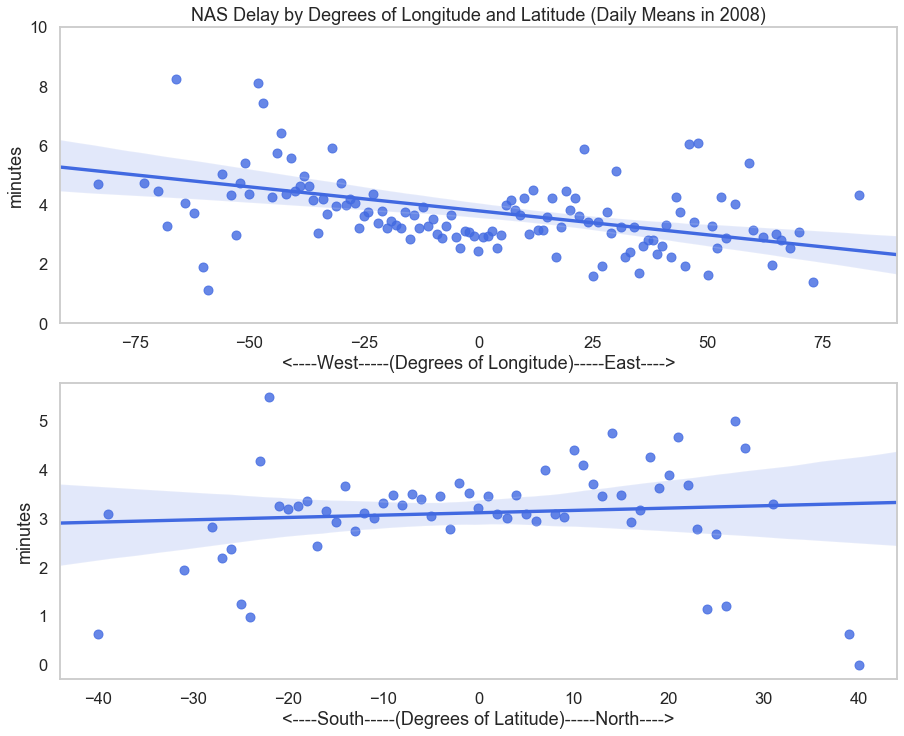

In [229]:
fig, ax = plt.subplots(nrows = 2, figsize = [15,12])

#It draws a regplot with the difference in long in the x-axis and the NAS delay in the y-axis 
sns.regplot(x="Difference_Long", y="NASDelay", data=df_routes_long, color="royalblue",ax = ax[0]);
ax[0].set_ylim(0,10)
ax[0].set_xlabel('<----West-----(Degrees of Longitude)-----East---->')
ax[0].set_ylabel('minutes')
ax[0].set_title('NAS Delay by Degrees of Longitude and Latitude (Daily Means in 2008)')

#It draws a regplot with the difference in latitude in the x-axis and the NAS delay in the y-axis 
sns.regplot(x="Difference_Lat", y="NASDelay", data=df_routes_lat, color="royalblue", ax = ax[1]);
ax[1].set_xlabel('<----South-----(Degrees of Latitude)-----North---->')
ax[1].set_ylabel('minutes')
#ax[1].set_title('NAS Delay by Degrees of Latitude (Daily Means in 2008)')
plt.show();

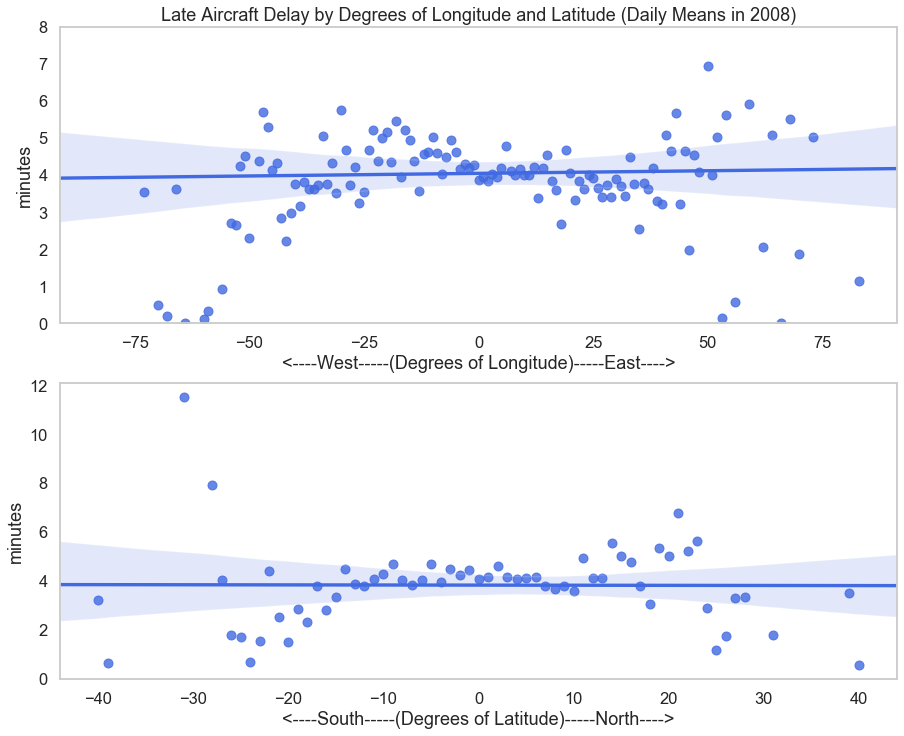

In [230]:
fig, ax = plt.subplots(nrows = 2, figsize = [15,12])

#It draws a regplot with the difference in long in the x-axis and the Late Aircraft delay in the y-axis 
sns.regplot(x="Difference_Long", y="LateAircraftDelay", data=df_routes_long, color="royalblue",ax = ax[0]);
ax[0].set_ylim(0,8)
ax[0].set_xlabel('<----West-----(Degrees of Longitude)-----East---->')
ax[0].set_ylabel('minutes')
ax[0].set_title('Late Aircraft Delay by Degrees of Longitude and Latitude (Daily Means in 2008)')

#It draws a regplot with the difference in latitude in the x-axis and the Late Aircraft delay in the y-axis 
sns.regplot(x="Difference_Lat", y="LateAircraftDelay", data=df_routes_lat, color="royalblue", ax = ax[1]);
ax[1].set_xlabel('<----South-----(Degrees of Latitude)-----North---->')
ax[1].set_ylabel('minutes')
#ax[1].set_title('Late Aircraft Delay by Degrees of Latitude (Daily Means in 2008)')
plt.show();

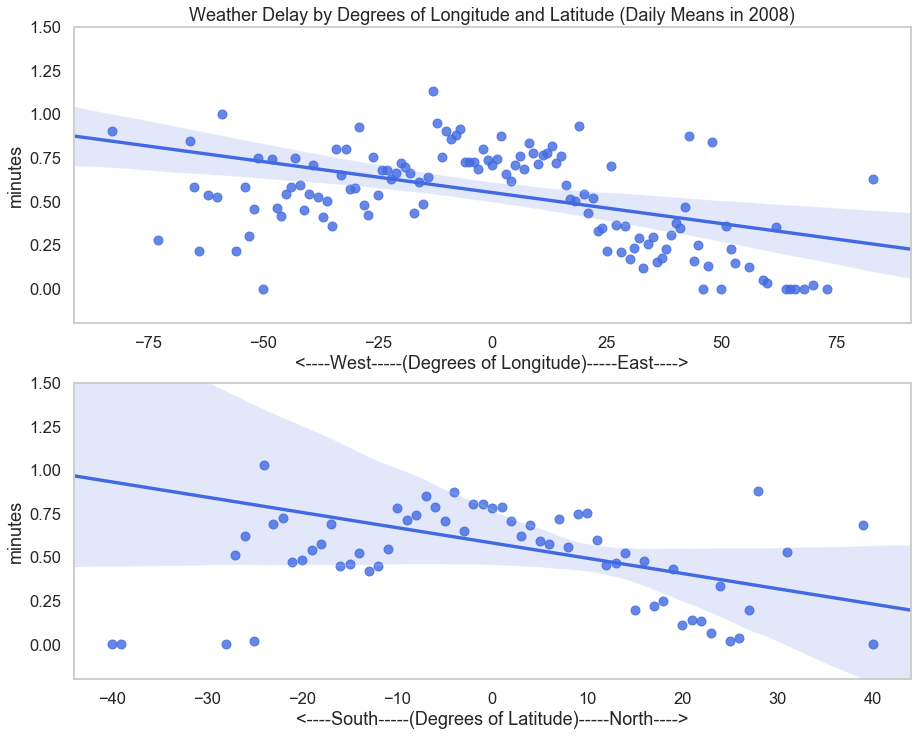

In [231]:
fig, ax = plt.subplots(nrows = 2, figsize = [15,12])

#It draws a regplot with the difference in long in the x-axis and the Weather delay in the y-axis 
sns.regplot(x="Difference_Long", y="WeatherDelay", data=df_routes_long, color="royalblue",ax = ax[0]);
ax[0].set_ylim(-0.2,1.5)
ax[0].set_xlabel('<----West-----(Degrees of Longitude)-----East---->')
ax[0].set_ylabel('minutes')
ax[0].set_title('Weather Delay by Degrees of Longitude and Latitude (Daily Means in 2008)')

#It draws a regplot with the difference in latitude in the x-axis and the Weather delay in the y-axis 
sns.regplot(x="Difference_Lat", y="WeatherDelay", data=df_routes_lat, color="royalblue", ax = ax[1]);
ax[1].set_ylim(-0.2,1.5)
ax[1].set_xlabel('<----South-----(Degrees of Latitude)-----North---->')
ax[1].set_ylabel('minutes')
#ax[1].set_title('Weather Delay by Degrees of Latitude (Daily Means in 2008)')
plt.show();

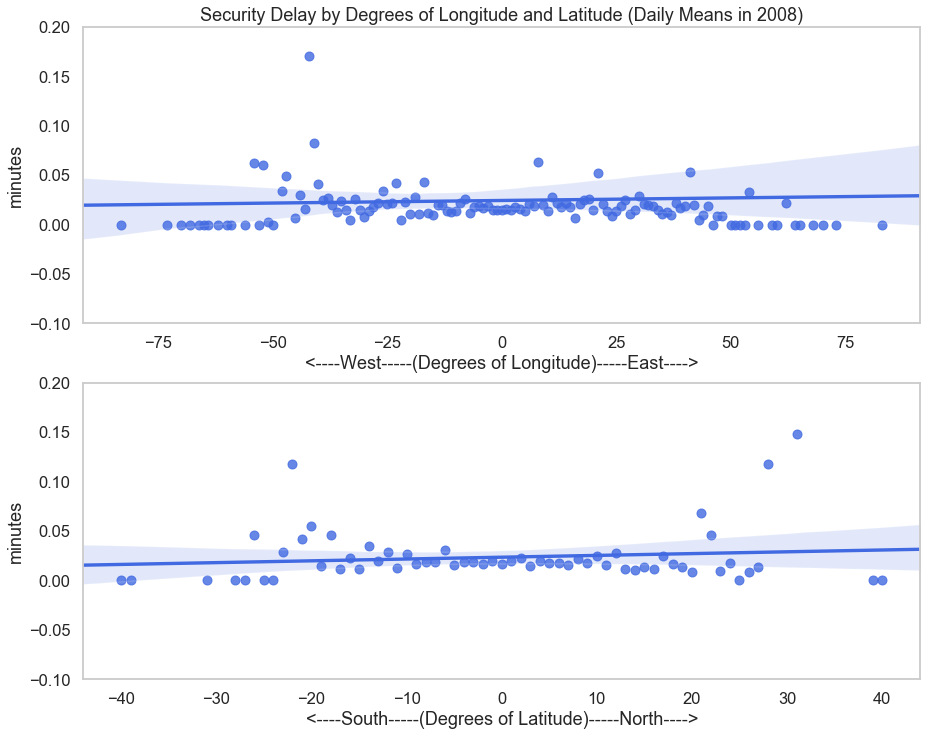

In [232]:
fig, ax = plt.subplots(nrows = 2, figsize = [15,12])

#It draws a regplot with the difference in long in the x-axis and the Security delay in the y-axis 
sns.regplot(x="Difference_Long", y="SecurityDelay", data=df_routes_long, color="royalblue",ax = ax[0]);
ax[0].set_ylim(-0.1,0.2)
ax[0].set_xlabel('<----West-----(Degrees of Longitude)-----East---->')
ax[0].set_ylabel('minutes')
ax[0].set_title('Security Delay by Degrees of Longitude and Latitude (Daily Means in 2008)')

#It draws a regplot with the difference in latitude in the x-axis and the Weather delay in the y-axis 
sns.regplot(x="Difference_Lat", y="SecurityDelay", data=df_routes_lat, color="royalblue", ax = ax[1]);
ax[1].set_ylim(-0.1,0.2)
ax[1].set_xlabel('<----South-----(Degrees of Latitude)-----North---->')
ax[1].set_ylabel('minutes')
#ax[1].set_title('Security Delay by Degrees of Latitude (Daily Means in 2008)')
plt.show();

## Analysis of Alternatives to Air Transport

Analyzing the routes with more than 15 flights per day and with a mean speed slower than 250 km/h we have found 96 routes in 2008 that can describe some possible options to develop another mean of transport more ecological like the high speed trains. We have chose these parameters trying to find busy routes and with a mean speed low enough so that it is more easy for a train to compete: 

* One of this options could be a line from San Francisco to Los Angeles and Phoenix.


* Other option could be from Boston to New York, Atlanta and Miami.


* And to link the both coast we could make a corridor beteen the New York area, Chicago, Denver and Los Angeles.

![Busy Slow Rutes](pictures/Busy_Slow_Routes.jpg)